In [19]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

dde.config.set_default_float("float32")
dde.config.real.set_float32()


Set the default float type to float32


# I am solving for such system of masses provided below

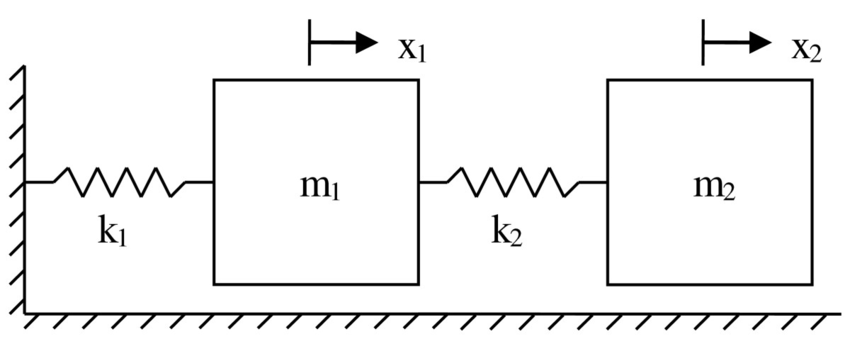

In [20]:
# masses and spring Constants
m1, m2 = 1.0, 1.0
k1, k2 = 5.0, 2.0
L1, L2 = 0.5, 0.5
b1, b2 = 0.0, 0.0  # damping

# initial Conditions
d1_0, d2_0 = 0.5, 3.25
v1_0, v2_0 = 0.0, 0.0
t_max = 5


In [21]:
def dy(t, x):
    return dde.grad.jacobian(x, t)

def pde(t, x):
    x1 = x[:, 0:1]
    x2 = x[:, 1:2]

    dx1_tt = dde.grad.hessian(x, t, i=0, j=0, component=0)
    dx2_tt = dde.grad.hessian(x, t, i=0, j=0, component=1)

    pde1 = m1 * dx1_tt + k1 * (x1 - L1) - k2 * (x2 - x1 - L2)
    pde2 = m2 * dx2_tt + k2 * (x2 - x1 - L2)

    return [pde1, pde2]


In [22]:
def boundary_init(t, on_boundary):
    return on_boundary and np.isclose(t[0], 0)

geom = dde.geometry.TimeDomain(0, t_max)

# Displacement BCs at t = 0
init_d1 = dde.icbc.PointSetBC(np.array([[0.0]]), np.array([[d1_0]]), component=0)
init_d2 = dde.icbc.PointSetBC(np.array([[0.0]]), np.array([[d2_0]]), component=1)

# Velocity BCs at t = 0
init_v1 = dde.OperatorBC(geom, lambda x, y, _: dy(x, y[:, 0:1]), boundary_init)
init_v2 = dde.OperatorBC(geom, lambda x, y, _: dy(x, y[:, 1:2]), boundary_init)

data = dde.data.PDE(
    geom, pde, [init_d1, init_d2, init_v1, init_v2],
    num_domain=2000,
    num_boundary=100,
    num_test=1000,
)


In [23]:
layer_size = [1] + [20] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)


In [24]:
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=5000)


Compiling model...
Building feed-forward neural network...
'build' took 0.068003 s

'compile' took 0.988525 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.21e+00, 4.90e-01, 2.50e-01, 1.06e+01, 4.28e-03, 1.12e-01]    [1.21e+00, 4.72e-01, 2.50e-01, 1.06e+01, 4.28e-03, 1.12e-01]    []  
1000      [1.38e-01, 9.39e-02, 1.60e-01, 4.60e-02, 1.02e-04, 1.08e-05]    [1.42e-01, 8.80e-02, 1.60e-01, 4.60e-02, 1.02e-04, 1.08e-05]    []  
2000      [7.19e-02, 2.67e-02, 5.91e-02, 7.53e-03, 2.14e-04, 3.18e-04]    [7.55e-02, 2.20e-02, 5.91e-02, 7.53e-03, 2.14e-04, 3.18e-04]    []  
3000      [1.31e-02, 4.72e-03, 5.99e-03, 7.69e-04, 7.26e-06, 1.43e-05]    [1.29e-02, 4.56e-03, 5.99e-03, 7.69e-04, 7.26e-06, 1.43e-05]    []  
4000      [3.94e-03, 1.24e-03, 1.05e-03, 1.32e-04, 1.49e-06, 1.69e-07]    [3.96e-03, 1.28e-03, 1.05e-03, 1.32e-04, 1.49e-06, 1.69e-07]    []  
5000 

In [25]:
dde.optimizers.config.set_LBFGS_options(maxiter=5000)
model.compile("L-BFGS")
losshistory, train_state = model.train()


Compiling model...
'compile' took 1.161635 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
5000      [1.97e-02, 1.36e-03, 1.98e-04, 9.98e-09, 1.36e-04, 8.21e-05]    [2.03e-02, 1.40e-03, 1.98e-04, 9.98e-09, 1.36e-04, 8.21e-05]    []  
5017      [1.97e-02, 1.36e-03, 1.98e-04, 9.98e-09, 1.36e-04, 8.21e-05]    [2.03e-02, 1.40e-03, 1.98e-04, 9.98e-09, 1.36e-04, 8.21e-05]    []  

Best model at step 4000:
  train loss: 6.37e-03
  test loss: 6.43e-03
  test metric: []

'train' took 5.907614 s



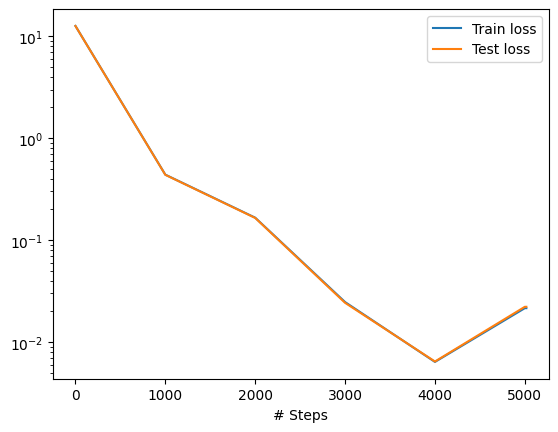

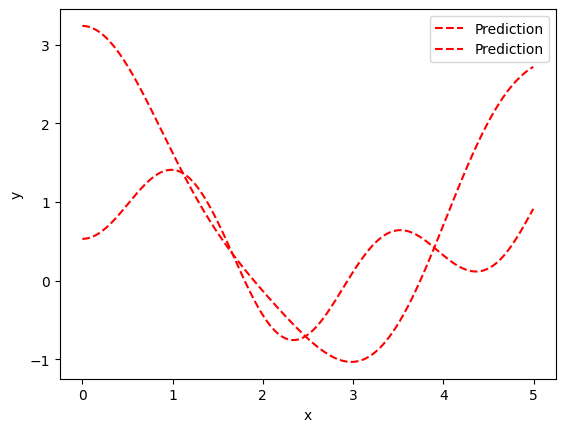

In [26]:
# Loss and accuracy plots from history
dde.saveplot(losshistory, train_state, issave=False, isplot=True)


In [27]:
def vectorfield(w, t, p):
    x1, y1, x2, y2 = w
    m1, m2, k1, k2, L1, L2, b1, b2 = p
    return [
        y1,
        (-b1 * y1 - k1 * (x1 - L1) + k2 * (x2 - x1 - L2)) / m1,
        y2,
        (-b2 * y2 - k2 * (x2 - x1 - L2)) / m2,
    ]

abserr, relerr = 1e-8, 1e-6
numpoints = 250
t = np.linspace(0, t_max, numpoints).reshape(-1, 1)
p = [m1, m2, k1, k2, L1, L2, b1, b2]
w0 = [d1_0, v1_0, d2_0, v2_0]

wsol = odeint(vectorfield, w0, t[:, 0], args=(p,), atol=abserr, rtol=relerr)


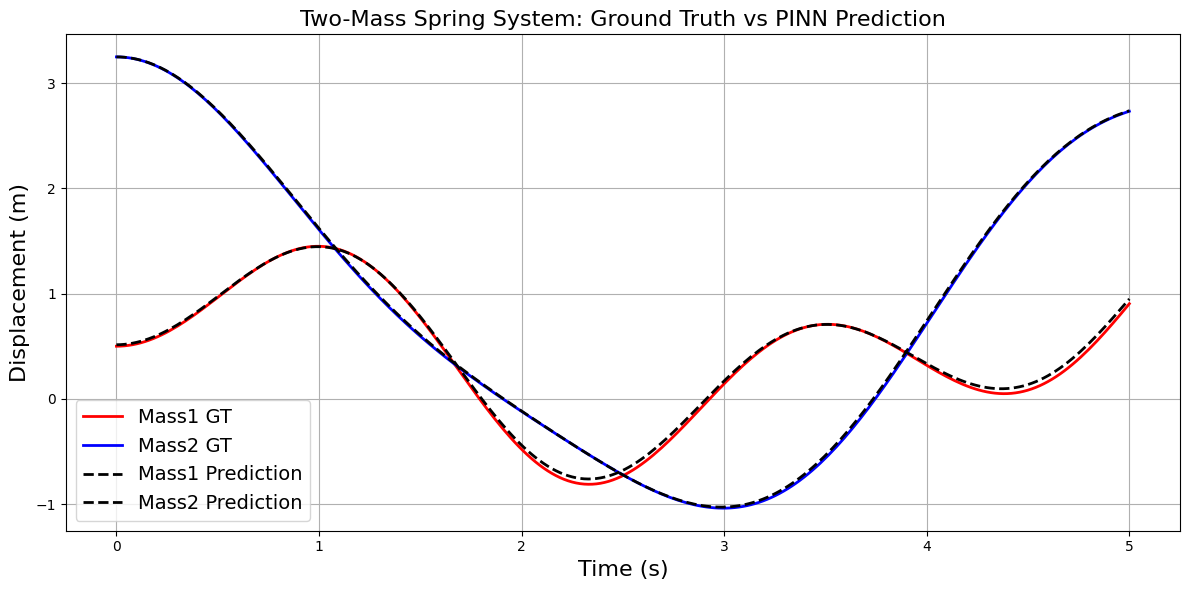

In [28]:
result = model.predict(t)
usol1 = result[:, 0]
usol2 = result[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(t, wsol[:, 0], label="Mass1 GT", color="r", lw=2)
plt.plot(t, wsol[:, 2], label="Mass2 GT", color="b", lw=2)
plt.plot(t, usol1, "--", label="Mass1 Prediction", color="k", lw=2)
plt.plot(t, usol2, "--", label="Mass2 Prediction", color="k", lw=2)

plt.legend(fontsize=14)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Displacement (m)", fontsize=16)
plt.title("Two-Mass Spring System: Ground Truth vs PINN Prediction", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
